# **0. Introduction**

Following is a speech emotion recogniton model developed using Deep Learning. We used speech data, combined from 4 different datasets (SAVEE, RAVDESS, TESS, CREMA-D), unlike the academic paper referenced below which only used RAVDESS dataset, and optimized them for usage by making their properties similar (adjusting sampling_rate, duration of audio extracted etc.). 

Then we extracted the MFCC (Mel Frequency Cepstral Coefficient) for each sample, which is quite a mandatory preprocessing step for audio files before feeding them to a CNN model.

Our process for this speech emotion recognition module is inspired from the following academic research paper:

"Murugan, Harini. (2020). Speech Emotion Recognition Using CNN. International Journal of Psychosocial Rehabilitation. 24. 10.37200/IJPR/ V24I8/PR280260."

https://www.researchgate.net/publication/342231090_Speech_Emotion_Recognition_Using_CNN

# **1. Importing Libraries**

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import IPython.display as ipd  
import zipfile
import pickle
import os
import sys
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping



# **2. Loading files from Drive**

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
path = '/drive/MyDrive/AudioDatasets/'

with zipfile.ZipFile(path+"RAVDESS_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("RAVDESS_Dataset")

with zipfile.ZipFile(path+"SAVEE_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("SAVEE_Dataset")

with zipfile.ZipFile(path+"CREMA-D_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("CREMA-D_Dataset")

with zipfile.ZipFile(path+"TESS_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("TESS_Dataset")

In [ ]:
TESS_dataset = "TESS_Dataset/TESS Toronto emotional speech set data/"
RAVDESS_dataset = "RAVDESS_Dataset/"
SAVEE_dataset = "SAVEE_Dataset/"
CREMA_dataset = "CREMA-D_Dataset/AudioWAV/"

savee_dir_list = os.listdir(SAVEE_dataset)
savee_dir_list[:10]

['a01_KL.wav',
 'a15_JE.wav',
 'n03_JE.wav',
 'f02_JE.wav',
 'n22_DC.wav',
 'su15_KL.wav',
 'f03_DC.wav',
 'sa04_DC.wav',
 'h15_JK.wav',
 'su08_KL.wav']

# **3. Initial analysis of our datasets**

## i) SAVEE Dataset

SAVEE stands for Surrey Audio-Visual Expressed Emotion. The dataset consists of the voice of 4 male speakers only. It consists of 7 emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral).

For more details about the dataset, visit http://kahlan.eps.surrey.ac.uk/savee/Database.html

In [ ]:
emotion=[]
path = []
for file_name in savee_dir_list:
    if file_name[0:1]=='a':
        emotion.append('male_angry')
    elif file_name[0:1]=='d':
        emotion.append('male_disgust')
    elif file_name[0:1]=='f':
        emotion.append('male_fear')
    elif file_name[0:1]=='h':
        emotion.append('male_happy')
    elif file_name[0:1]=='n':
        emotion.append('male_neutral')
    elif file_name[0:2]=='sa':
        emotion.append('male_sad')
    elif file_name[0:2]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE_dataset + file_name)
    
     
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_sad          60
male_angry        60
male_fear         60
male_happy        60
male_surprise     60
male_disgust      60
Name: labels, dtype: int64

In [ ]:
SAVEE_df

labels source                       path
0      male_angry  SAVEE   SAVEE_Dataset/a01_KL.wav
1      male_angry  SAVEE   SAVEE_Dataset/a15_JE.wav
2    male_neutral  SAVEE   SAVEE_Dataset/n03_JE.wav
3       male_fear  SAVEE   SAVEE_Dataset/f02_JE.wav
4    male_neutral  SAVEE   SAVEE_Dataset/n22_DC.wav
..            ...    ...                        ...
475     male_fear  SAVEE   SAVEE_Dataset/f05_JE.wav
476  male_neutral  SAVEE   SAVEE_Dataset/n17_JE.wav
477      male_sad  SAVEE  SAVEE_Dataset/sa13_JK.wav
478      male_sad  SAVEE  SAVEE_Dataset/sa09_JE.wav
479  male_neutral  SAVEE   SAVEE_Dataset/n19_KL.wav

[480 rows x 3 columns]

SAVEE Angry sample


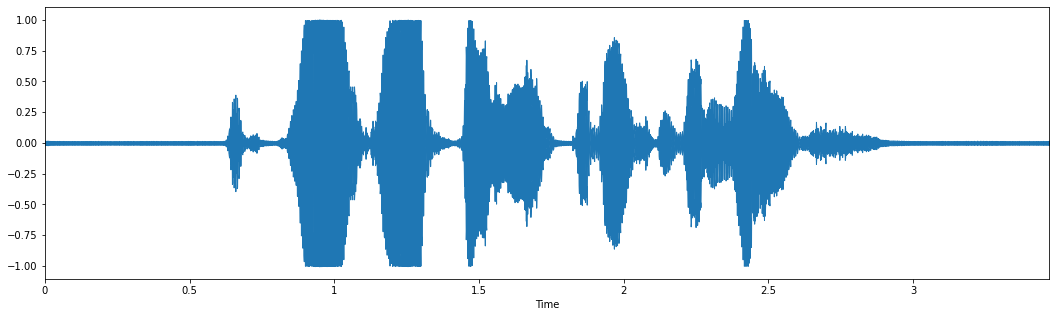

In [ ]:
fname = SAVEE_dataset + 'a08_DC.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("SAVEE Angry sample")
ipd.Audio(fname)

SAVEE Happy sample


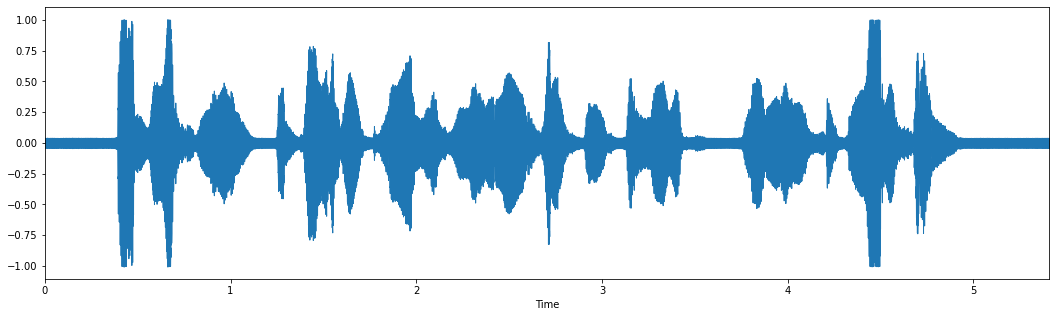

In [ ]:
fname = SAVEE_dataset + 'h14_DC.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("SAVEE Happy sample")
ipd.Audio(fname)

## ii) RAVDESS Dataset

RAVDESS stands for Ryerson Audio-Visual Database of Emotional Speech and Song. It's a pretty versatile dataset, consisting of 
different vocals (speech, song), emotional intensities (normal,  strong), statements and actors. Like other datasets, it also consists of the same 7 emotions. 

This dataset is very preferable, since it adds variety to our model and will prevent it from overfitting. And also make it practically useful on unseen data.

**Citing the dataset:**
"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)"

More details about RAVDESS can be found in their academic paper: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391



In [ ]:
ravdess_dir_list = os.listdir(RAVDESS_dataset)
# ravdess_dir_list.sort()

emotion = []
gender = []
path = []
for i in ravdess_dir_list:
    fname = os.listdir(RAVDESS_dataset + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS_dataset + i + '/' + f)

        
RAVDESS_df = pd.DataFrame(emotion)
RAVDESS_df = RAVDESS_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVDESS_df = pd.concat([pd.DataFrame(gender),RAVDESS_df],axis=1)
RAVDESS_df.columns = ['gender','emotion']
RAVDESS_df['labels'] =RAVDESS_df.gender + '_' + RAVDESS_df.emotion
RAVDESS_df['source'] = 'RAVDESS'  
RAVDESS_df = pd.concat([RAVDESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVDESS_df = RAVDESS_df.drop(['gender', 'emotion'], axis=1)
RAVDESS_df.labels.value_counts()

male_neutral       144
female_neutral     144
female_sad          96
female_surprise     96
female_disgust      96
male_angry          96
female_angry        96
female_fear         96
female_happy        96
male_sad            96
male_fear           96
male_happy          96
male_surprise       96
male_disgust        96
Name: labels, dtype: int64

In [ ]:
RAVDESS_df

labels   source                                               path
0      male_neutral  RAVDESS  RAVDESS_Dataset/Actor_11/03-01-02-01-01-01-11.wav
1        male_angry  RAVDESS  RAVDESS_Dataset/Actor_11/03-01-05-02-01-02-11.wav
2      male_neutral  RAVDESS  RAVDESS_Dataset/Actor_11/03-01-02-02-02-02-11.wav
3        male_happy  RAVDESS  RAVDESS_Dataset/Actor_11/03-01-03-01-02-01-11.wav
4      male_neutral  RAVDESS  RAVDESS_Dataset/Actor_11/03-01-02-02-01-01-11.wav
...             ...      ...                                                ...
1435      male_fear  RAVDESS  RAVDESS_Dataset/Actor_23/03-01-06-01-01-02-23.wav
1436     male_happy  RAVDESS  RAVDESS_Dataset/Actor_23/03-01-03-02-01-02-23.wav
1437      male_fear  RAVDESS  RAVDESS_Dataset/Actor_23/03-01-06-02-01-01-23.wav
1438  male_surprise  RAVDESS  RAVDESS_Dataset/Actor_23/03-01-08-01-02-02-23.wav
1439  male_surprise  RAVDESS  RAVDESS_Dataset/Actor_23/03-01-08-01-01-01-23.wav

[1440 rows x 3 columns]

RAVDESS Angry sample


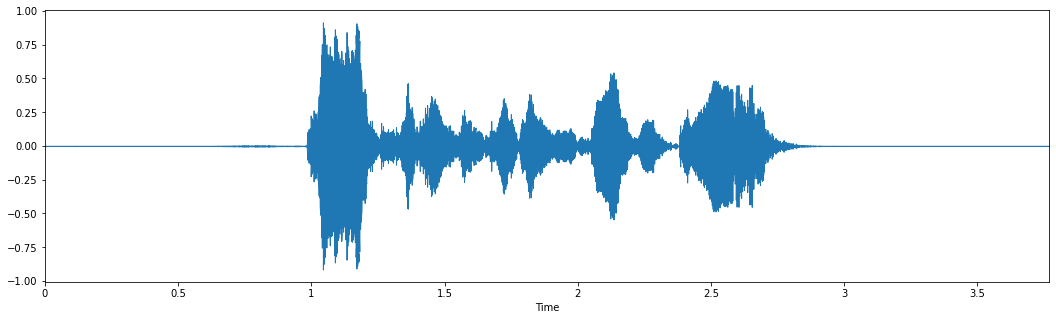

In [ ]:
fname = RAVDESS_dataset + 'Actor_11/03-01-05-02-02-02-11.wav'   #05 = Angry 
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("RAVDESS Angry sample")
ipd.Audio(fname)

RAVDESS Happy sample


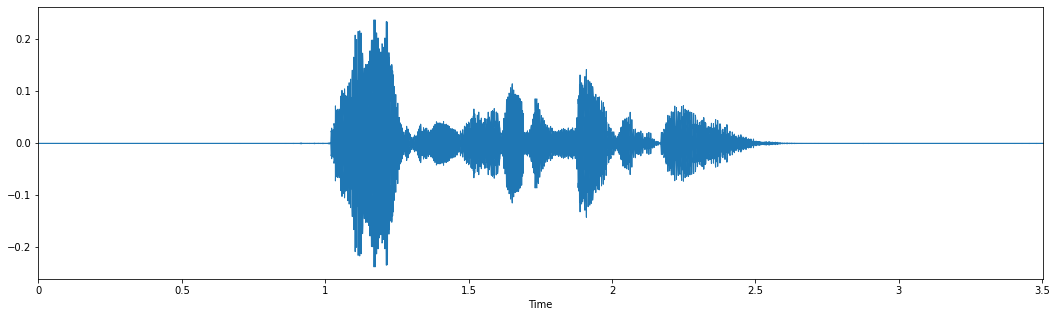

In [ ]:
fname = RAVDESS_dataset + 'Actor_11/03-01-03-02-02-02-11.wav'   # 03 = Happy  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("RAVDESS Happy sample")
ipd.Audio(fname)

## iii) TESS Dataset

TESS is an abbreviation for Toronto emotional speech set. A dataset of 2800 audio files, consisting of a set of 7 emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Consists of voices of only two females, which is good for
our dataset since it was male dominant before.

For more details about the dataset, follow this link:
https://tspace.library.utoronto.ca/handle/1807/24487

In [ ]:
tess_dir_list = os.listdir(TESS_dataset)
tess_dir_list

emotion = []
path = []

for i in tess_dir_list:
    fname = os.listdir(TESS_dataset + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS_dataset + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_surprise    400
female_angry       400
female_happy       400
female_sad         400
female_disgust     400
female_neutral     400
female_fear        400
Name: labels, dtype: int64

In [ ]:
TESS_df

labels source                                               path
0     female_angry   TESS  TESS_Dataset/TESS Toronto emotional speech set...
1     female_angry   TESS  TESS_Dataset/TESS Toronto emotional speech set...
2     female_angry   TESS  TESS_Dataset/TESS Toronto emotional speech set...
3     female_angry   TESS  TESS_Dataset/TESS Toronto emotional speech set...
4     female_angry   TESS  TESS_Dataset/TESS Toronto emotional speech set...
...            ...    ...                                                ...
2795    female_sad   TESS  TESS_Dataset/TESS Toronto emotional speech set...
2796    female_sad   TESS  TESS_Dataset/TESS Toronto emotional speech set...
2797    female_sad   TESS  TESS_Dataset/TESS Toronto emotional speech set...
2798    female_sad   TESS  TESS_Dataset/TESS Toronto emotional speech set...
2799    female_sad   TESS  TESS_Dataset/TESS Toronto emotional speech set...

[2800 rows x 3 columns]

TESS Angry sample


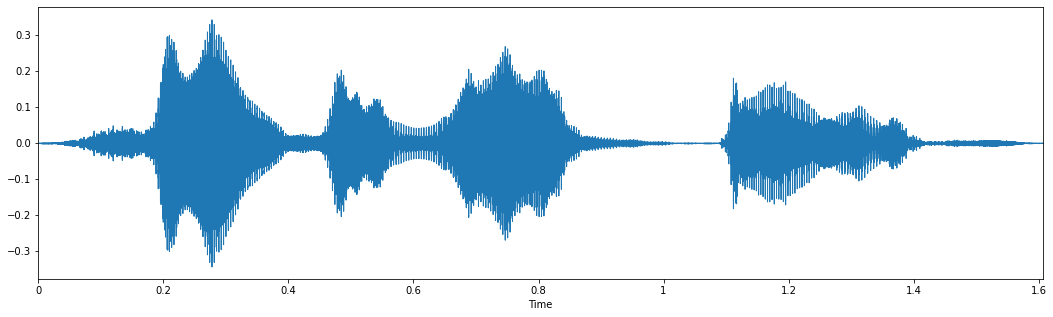

In [ ]:
fname = TESS_dataset + "OAF_angry/OAF_bath_angry.wav"   # 03 = Happy  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("TESS Angry sample")
ipd.Audio(fname)

TESS Happy sample


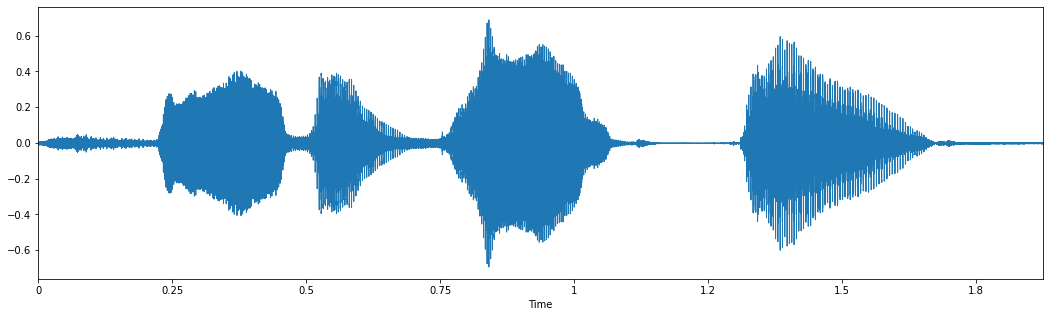

In [ ]:
fname = TESS_dataset + "YAF_happy/YAF_bath_happy.wav"   # 03 = Happy  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("TESS Happy sample")
ipd.Audio(fname)

## iv) CREMA-D Dataset

CREMA-D is abbreviated for Crowd Sourced Emotional Multimodal Actors Dataset. It's also a big dataset like RAVDESS, consisting of almost 7442 clips from over 90 actors. This dataset is particularly used to introduce variety to our model and make it practically usable on real life data.

In [ ]:
crema_dir_list = os.listdir(CREMA_dataset)
print(crema_dir_list[:10])

gender = []
emotion = []
path = []
female_ids = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]
male_ids = [1001,1005,1011,1014,1015,1016,1017,1019,1022,1023,1026,1027,1031,1032,1033,1034,1035,1036,1038,1039,1040,
            1041,1042,1044,1045,1048,1050,1051,1057,1059,1062,1064,1065,1066,1067,1068,1069,1070,1071,1077,1080,1081,1083,
            1085,1086,1087,1088,1090]

for i in crema_dir_list: 
    part = i.split('_')
    if int(part[0]) in male_ids:
        temp = 'male'
    else:
        temp = 'female'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA_dataset + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

['1077_TIE_NEU_XX.wav', '1043_ITH_SAD_XX.wav', '1009_IOM_NEU_XX.wav', '1088_MTI_HAP_XX.wav', '1038_TSI_ANG_XX.wav', '1067_IWL_NEU_XX.wav', '1072_TSI_DIS_XX.wav', '1026_TAI_FEA_XX.wav', '1052_WSI_DIS_XX.wav', '1055_IOM_ANG_XX.wav']


male_sad          671
male_angry        671
male_fear         671
male_happy        671
male_disgust      671
female_sad        600
female_angry      600
female_happy      600
female_disgust    600
female_fear       600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [ ]:
CREMA_df

labels source                                          path
0       male_neutral  CREMA  CREMA-D_Dataset/AudioWAV/1077_TIE_NEU_XX.wav
1         female_sad  CREMA  CREMA-D_Dataset/AudioWAV/1043_ITH_SAD_XX.wav
2     female_neutral  CREMA  CREMA-D_Dataset/AudioWAV/1009_IOM_NEU_XX.wav
3         male_happy  CREMA  CREMA-D_Dataset/AudioWAV/1088_MTI_HAP_XX.wav
4         male_angry  CREMA  CREMA-D_Dataset/AudioWAV/1038_TSI_ANG_XX.wav
...              ...    ...                                           ...
7437  female_disgust  CREMA  CREMA-D_Dataset/AudioWAV/1046_IWW_DIS_XX.wav
7438  female_disgust  CREMA  CREMA-D_Dataset/AudioWAV/1002_IEO_DIS_LO.wav
7439    male_neutral  CREMA  CREMA-D_Dataset/AudioWAV/1083_IOM_NEU_XX.wav
7440        male_sad  CREMA  CREMA-D_Dataset/AudioWAV/1071_ITH_SAD_XX.wav
7441    female_happy  CREMA  CREMA-D_Dataset/AudioWAV/1007_IEO_HAP_MD.wav

[7442 rows x 3 columns]

CREMA Happy sample


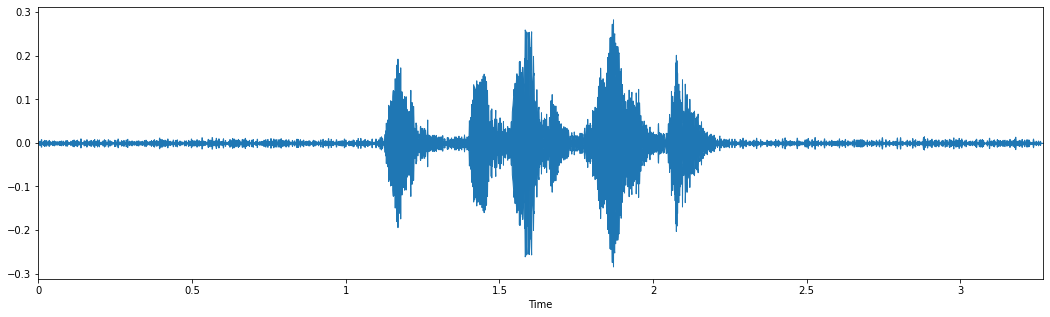

In [ ]:
fname = CREMA_dataset + "1003_DFA_HAP_XX.wav"   # HAP = Happy  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("CREMA Happy sample")
ipd.Audio(fname)

CREMA Angry sample


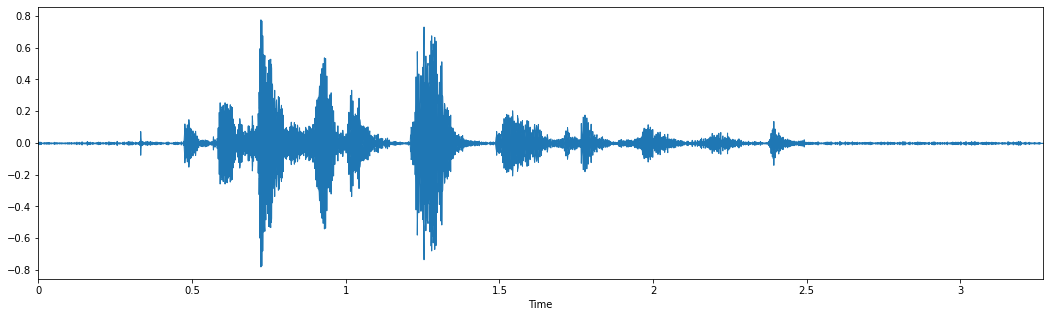

In [ ]:
fname = CREMA_dataset + "1004_ITH_ANG_XX.wav"   # ANG = Angry  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(18, 5))
librosa.display.waveplot(data, sr=sampling_rate)

print ("CREMA Angry sample")
ipd.Audio(fname)

## v) Concatenating all four datasets

Here we combine the data from all 4 datasets (SAVEE, RAVDESS, TESS, CREMA)

In [ ]:
concatenated_df = pd.concat([SAVEE_df, RAVDESS_df, TESS_df, CREMA_df], axis = 0)
print(concatenated_df.labels.value_counts())
concatenated_df.head()
concatenated_df.to_csv("Concatenated_DF.csv",index=False)

female_happy       1096
female_sad         1096
female_angry       1096
female_disgust     1096
female_fear        1096
female_neutral     1056
male_neutral        839
male_sad            827
male_angry          827
male_happy          827
male_fear           827
male_disgust        827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


In [ ]:
# concatenated_df.head(10)
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12162 entries, 0 to 7441
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  12162 non-null  object
 1   source  12162 non-null  object
 2   path    12162 non-null  object
dtypes: object(3)
memory usage: 380.1+ KB


# **4. Feature Extraction (Visualizing MFCC in RAVDESS dataset)**

## i) Visualizing audio samples

MFCC stands for Mel Frequency Cepstral Coefficient. MFCCs are used in speech recognition tasks, such as extracting numbers from a speech. Recently its also being applied in music related applications such as genre classification, audio similarity measure etc. Here we will be using it for our speech datasets.

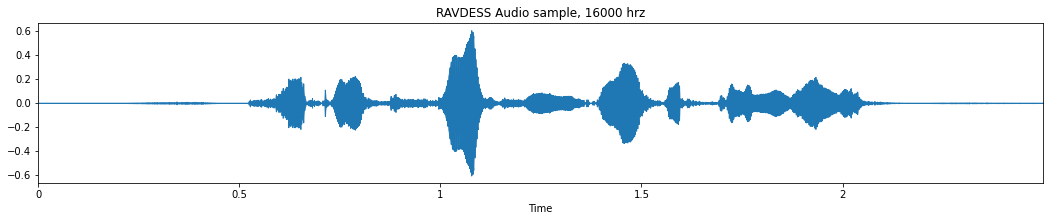

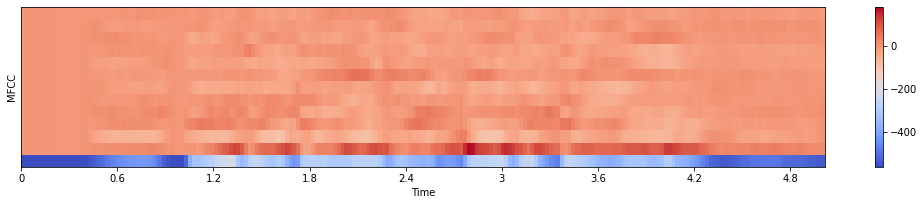

In [ ]:
sampling_rate = 44100

path = RAVDESS_dataset+"Actor_08/03-01-06-02-01-01-08.wav"  # Even = Female,  #06 = Angry
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('RAVDESS Audio sample, 16000 hrz')

# MFCC
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

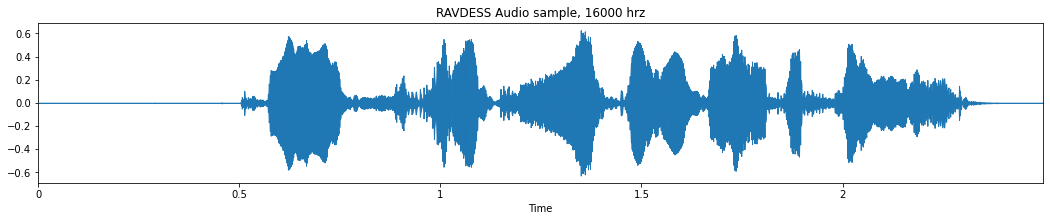

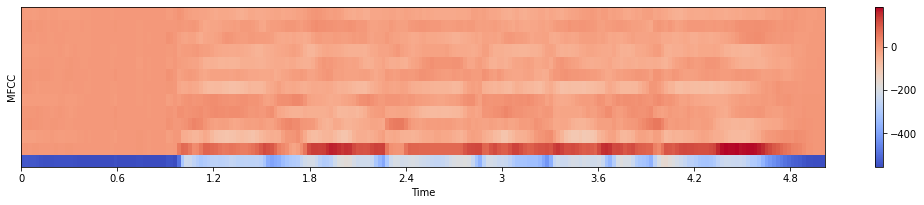

In [ ]:

path = RAVDESS_dataset+"Actor_10/03-01-03-02-01-01-10.wav"    # Even = Female,  #03 = Happy
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('RAVDESS Audio sample, 16000 hrz')

# MFCC
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

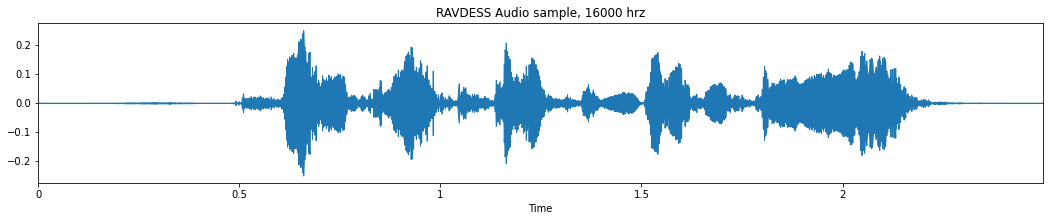

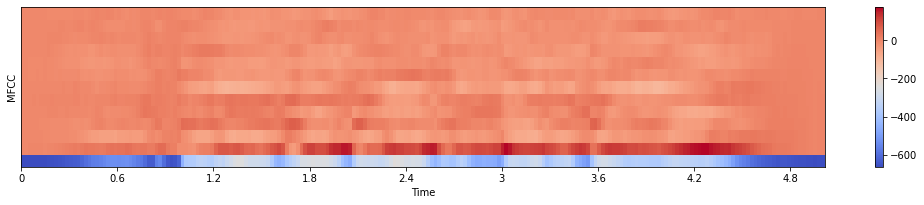

In [ ]:

path = RAVDESS_dataset+"Actor_07/03-01-06-02-01-01-07.wav"  # Odd = Male,  #06 = Angry
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('RAVDESS Audio sample, 16000 hrz')

# MFCC
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

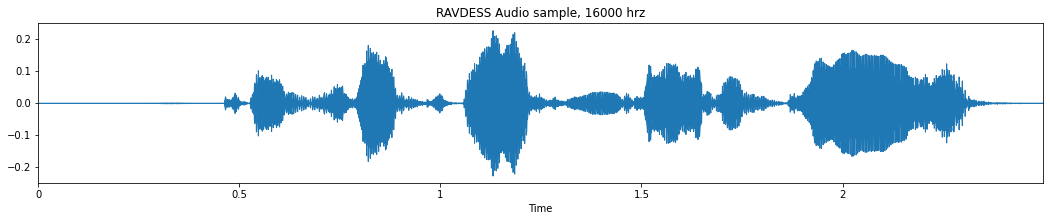

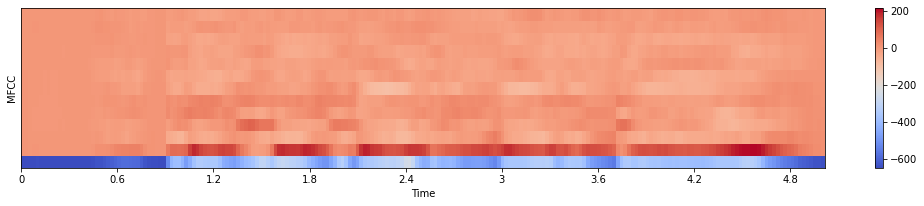

In [ ]:

path = RAVDESS_dataset+"Actor_09/03-01-03-02-01-01-09.wav"  # Odd = Male,  #03 = Happy
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('RAVDESS Audio sample, 16000 hrz')

# MFCC
plt.figure(figsize=(18, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

## ii) Comparing features on graph

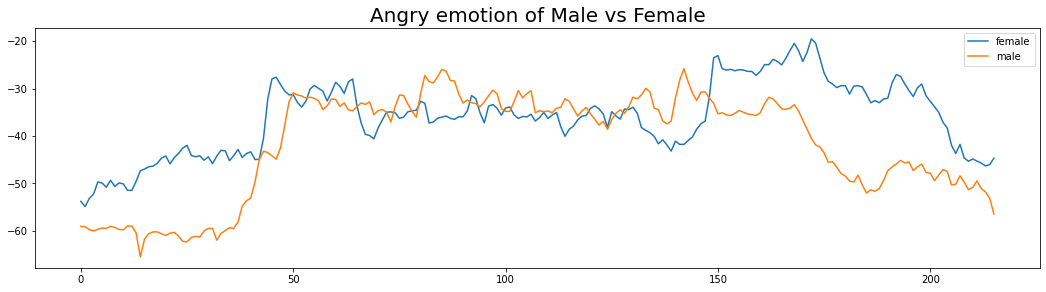

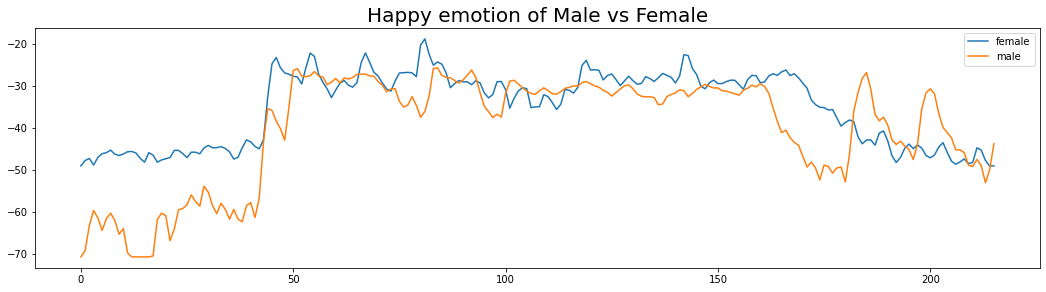

In [ ]:

path = RAVDESS_dataset+"Actor_08/03-01-06-01-01-01-08.wav"  # Even = Female,  #06 = Angry
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

path = RAVDESS_dataset+"Actor_07/03-01-06-01-01-01-07.wav"  # Odd = Male,  #06 = Angry
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

plt.figure(figsize=(18, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.title("Angry emotion of Male vs Female", fontdict = {'fontsize' : 20})
plt.legend()

path = RAVDESS_dataset+"Actor_10/03-01-03-01-01-01-10.wav"    # Even = Female,  #03 = Happy
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

path = RAVDESS_dataset+"Actor_09/03-01-03-01-01-01-09.wav"  # Odd = Male,  #03 = Happy
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

plt.figure(figsize=(18, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.title("Happy emotion of Male vs Female", fontdict = {'fontsize' : 20})
plt.legend()

# **5. Preprocessing concatenated data**

## i) Loading the concatenated dataframe

In [ ]:
concatenated_df = pd.read_csv("Concatenated_DF.csv")
concatenated_df

labels source                                          path
0          male_angry  SAVEE                      SAVEE_Dataset/a01_KL.wav
1          male_angry  SAVEE                      SAVEE_Dataset/a15_JE.wav
2        male_neutral  SAVEE                      SAVEE_Dataset/n03_JE.wav
3           male_fear  SAVEE                      SAVEE_Dataset/f02_JE.wav
4        male_neutral  SAVEE                      SAVEE_Dataset/n22_DC.wav
...               ...    ...                                           ...
12157  female_disgust  CREMA  CREMA-D_Dataset/AudioWAV/1046_IWW_DIS_XX.wav
12158  female_disgust  CREMA  CREMA-D_Dataset/AudioWAV/1002_IEO_DIS_LO.wav
12159    male_neutral  CREMA  CREMA-D_Dataset/AudioWAV/1083_IOM_NEU_XX.wav
12160        male_sad  CREMA  CREMA-D_Dataset/AudioWAV/1071_ITH_SAD_XX.wav
12161    female_happy  CREMA  CREMA-D_Dataset/AudioWAV/1007_IEO_HAP_MD.wav

[12162 rows x 3 columns]

In [ ]:
concatenated_df_copy = concatenated_df.copy()

labelss = []
for label in concatenated_df['labels']:
  labelss.append(label.split('_')[1])

concatenated_df_copy['labels'] = labelss;
from collections import Counter
Counter (labelss)
concatenated_df_copy.to_csv("Concatenated_DF2.csv", index=False)
concatenated_df_copy

labels source                                          path
0        angry  SAVEE                      SAVEE_Dataset/a01_KL.wav
1        angry  SAVEE                      SAVEE_Dataset/a15_JE.wav
2      neutral  SAVEE                      SAVEE_Dataset/n03_JE.wav
3         fear  SAVEE                      SAVEE_Dataset/f02_JE.wav
4      neutral  SAVEE                      SAVEE_Dataset/n22_DC.wav
...        ...    ...                                           ...
12157  disgust  CREMA  CREMA-D_Dataset/AudioWAV/1046_IWW_DIS_XX.wav
12158  disgust  CREMA  CREMA-D_Dataset/AudioWAV/1002_IEO_DIS_LO.wav
12159  neutral  CREMA  CREMA-D_Dataset/AudioWAV/1083_IOM_NEU_XX.wav
12160      sad  CREMA  CREMA-D_Dataset/AudioWAV/1071_ITH_SAD_XX.wav
12161    happy  CREMA  CREMA-D_Dataset/AudioWAV/1007_IEO_HAP_MD.wav

[12162 rows x 3 columns]

## ii) Extracting MFCCs for the concatenated dataset

Our original concatenated dataframe only consists of labels, source and path columns. In the following jupyter cells, we will be adding the MFCC columns to the dataframe too.

In [ ]:
df = pd.DataFrame(columns=['feature'])

counter=0
for index,path in enumerate(tqdm(concatenated_df.path)):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sampling_rate,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

print(len(df))
df.head()

100%|██████████| 12162/12162 [28:21<00:00,  7.15it/s]

12162


feature
0  [-17.843361802222784, -18.257282004477364, -18...
1  [-26.18319802787784, -25.84634333676388, -26.0...
2  [-25.435942209448324, -25.806043108198164, -26...
3  [-25.215380582447672, -25.36858455298433, -26....
4  [-11.855140862434668, -12.375480566708024, -13...

In [ ]:
df = pd.concat([concatenated_df,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df=df.fillna(0)
print(df.shape)
df[:10]

(12162, 219)


labels source  ...        214        215
0     male_angry  SAVEE  ... -22.115556 -20.083573
1     male_angry  SAVEE  ...  -2.289875   1.643087
2   male_neutral  SAVEE  ...   0.000000   0.000000
3      male_fear  SAVEE  ... -17.319082 -18.697047
4   male_neutral  SAVEE  ... -25.889760 -25.758463
5  male_surprise  SAVEE  ... -37.977450 -35.346636
6      male_fear  SAVEE  ...   0.000000   0.000000
7       male_sad  SAVEE  ...  -6.743683  -1.831447
8     male_happy  SAVEE  ...   0.568928   3.092341
9  male_surprise  SAVEE  ... -28.172668 -27.742403

[10 rows x 219 columns]

In [ ]:
X = df.drop(['path','labels','source'],axis=1)
y = df.labels

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=16)

X_train[1100:1110]

0          1          2    ...        213        214        215
4801 -12.144459 -12.004716 -13.572403  ...   0.000000   0.000000   0.000000
7269 -17.718831 -15.297842 -12.900944  ... -19.020181 -20.108519 -19.158818
6024  -0.172213  -3.912108 -10.863575  ...   0.000000   0.000000   0.000000
78   -25.238073 -23.353787 -24.034416  ... -16.140637 -10.035143  -5.949310
9281 -22.857356 -21.734089 -21.487664  ...   0.000000   0.000000   0.000000
1434 -73.721577 -73.721577 -73.721577  ... -73.721577 -73.766076 -73.736292
2776 -16.164834 -19.362537 -24.351318  ...   0.000000   0.000000   0.000000
3532 -15.999137 -19.064329 -22.660942  ...   0.000000   0.000000   0.000000
9328 -20.430963 -20.454648 -19.376970  ...   0.000000   0.000000   0.000000
6933 -21.249605 -17.731097 -15.520293  ...   0.000000   0.000000   0.000000

[10 rows x 216 columns]

## iii) Normalizing and Encoding the dataset

Normalizing and One-Hot-Encoding the dataset to be trained by our Keras model.

In [ ]:
X_train_norm=(X_train-X_train.mean())/X_train.std()

X_test_norm=(X_test-X_test.mean())/X_test.std()


In [ ]:
X_train_norm = np.array(X_train_norm)
y_train = np.array(y_train)
X_test_norm = np.array(X_test_norm)
y_test = np.array(y_test)

labelEncoder = LabelEncoder()
y_train_enc = np_utils.to_categorical(labelEncoder.fit_transform(y_train))
y_test_enc = np_utils.to_categorical(labelEncoder.fit_transform(y_test))

print(X_train_norm.shape)
print(labelEncoder.classes_)
print(y_train_enc[0:10])

X_train_norm = np.expand_dims(X_train_norm, axis=2)
X_test_norm = np.expand_dims(X_test_norm, axis=2)
X_train_norm.shape

(9729, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(9729, 216, 1)

## iv) Using 7 labels

In [ ]:
y_train2 = []
y_test2 = []
for y in y_train:
  y_train2.append(y.split('_')[1])

for y in y_test:
  y_test2.append(y.split('_')[1])


labelEncoder2 = LabelEncoder()
y_train_enc2 = np_utils.to_categorical(labelEncoder2.fit_transform(y_train2))
y_test_enc2 = np_utils.to_categorical(labelEncoder2.fit_transform(y_test2))

print(labelEncoder2.classes_)
print(y_train2[0:10])
print (y_train_enc2[:10])
filename = 'labels_dump2'
outfile = open(filename,'wb')
pickle.dump(labelEncoder2,outfile)
outfile.close()

X_train_norm.shape

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['angry', 'disgust', 'neutral', 'surprise', 'disgust', 'fear', 'angry', 'angry', 'sad', 'happy']
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


(9729, 216, 1)

# **6. Basic Model using Keras**

## i) Using 14 labels (with gender classification like female_angry etc.)

Classifies the emotions into 14 different labels (with gender classification), using 1D CNNs, AveragePooling and Dense layers. See the model summary for more info. Gives a training accuracy of about 56%, and validation set accuracy of above 45%.

In [ ]:
model = Sequential()
model.add(Conv1D(64, 8, padding='same', activation='relu',input_shape=(X_train_norm.shape[1],1)))  

model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(AveragePooling1D(pool_size=(8)))

model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(AveragePooling1D(pool_size=(8)))
model.add(Conv1D(256, 8, padding='same', activation='relu'))
model.add(Conv1D(256, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(14, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 64)           576       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 64)           32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 64)           256       
_________________________________________________________________
dropout (Dropout)            (None, 216, 64)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 27, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           1

In [ ]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
filepath ="weights_label14/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = 'adam'
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train_norm, y_train_enc, batch_size=16, epochs=100, callbacks=[earlyStopping, model_checkpoint],
                        validation_data=(X_test_norm, y_test_enc))

Epoch 1/100
609/609 [==============================] - 13s 8ms/step - loss: 2.6754 - accuracy: 0.1874 - val_loss: 2.8218 - val_accuracy: 0.2199
Epoch 2/100
609/609 [==============================] - 4s 7ms/step - loss: 2.3071 - accuracy: 0.2299 - val_loss: 2.1618 - val_accuracy: 0.2655
Epoch 3/100
609/609 [==============================] - 5s 8ms/step - loss: 2.1394 - accuracy: 0.2699 - val_loss: 2.4012 - val_accuracy: 0.2441
Epoch 4/100
609/609 [==============================] - 4s 7ms/step - loss: 1.9976 - accuracy: 0.3097 - val_loss: 2.0764 - val_accuracy: 0.2939
Epoch 5/100
609/609 [==============================] - 4s 7ms/step - loss: 1.9221 - accuracy: 0.3270 - val_loss: 1.8544 - val_accuracy: 0.3662
Epoch 6/100
609/609 [==============================] - 4s 7ms/step - loss: 1.8380 - accuracy: 0.3620 - val_loss: 1.7651 - val_accuracy: 0.3781
Epoch 7/100
609/609 [==============================] - 4s 7ms/step - loss: 1.7805 - accuracy: 0.3866 - val_loss: 1.7191 - val_accuracy: 0.375

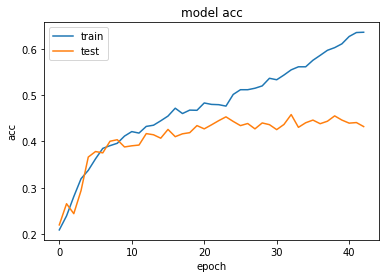

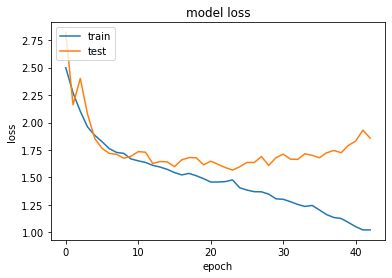

Max Validation accuracy:  0.4578709304332733


In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print ("Train accuracy: ", model_history.history['accuracy'][20])
print ("Max Validation accuracy: ", max(model_history.history['val_accuracy']))

## ii) Using 7 labels (without gender classification like surprise, angry etc.)

Classifies the emotions into 7 different labels (no gender classification), using 1D CNNs, AveragePooling and Dense layers. See the model summary for more info. Gives a training accuracy of 64%, and validation set accuracy of above 52%.

In [ ]:
new_model = tf.keras.models.Sequential(model.layers[:-1])
new_model.add(Dense(7, activation='softmax'))
new_model.summary()

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
filepath ="weights_label7/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = 'adam'
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

new_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=new_model.fit(X_train_norm, y_train_enc2, batch_size=16, epochs=100, callbacks=[earlyStopping, model_checkpoint],
                        validation_data=(X_test_norm, y_test_enc2))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 64)           576       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 64)           32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 64)           256       
_________________________________________________________________
dropout (Dropout)            (None, 216, 64)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 27, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)          

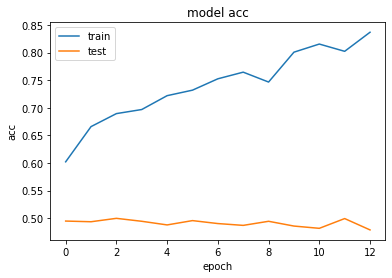

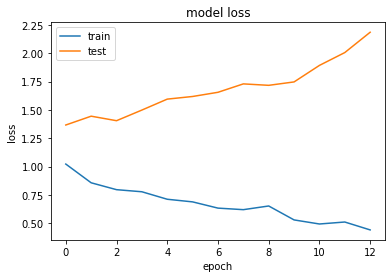

Max Validation accuracy:  0.49979448318481445


In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print ("Train accuracy: ", model_history.history['accuracy'][20])
print ("Max Validation accuracy: ", max(model_history.history['val_accuracy']))

## iii) Using augmentation for audio set (adding  noise, commented)

Tried to add augmentation (noise only) using a 3rd party library, but the accuracy wasn't much affected. Will try to change the pitch or speed later on, maybe that creates a difference. 

In [ ]:
# !git clone https://github.com/AhmedImtiazPrio/Keras-AudioDataGenerator

In [ ]:

# from Keras_AudioDataGenerator.AudioDataGenerator import AudioDataGenerator

# datagen = AudioDataGenerator(
#                 noise = [X_train_norm.min(), X_train_norm.max(), 'Uniform']
# )

# datagen.fit(X_train_norm)

# model_history2 = model.fit_generator(datagen.flow(X_train_norm,y_train_enc2,batch_size=32),
#                     steps_per_epoch = len(X_train_norm)/32,
#                     callbacks = [earlyStopping],
#                     validation_data = (X_test_norm, y_test_enc2),
#                     epochs = 100)

## iv) Saving the model (commented)

Saving the model file, weights and json separately.

In [ ]:
# model_json = model.to_json()

# with open("model_json.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights("model_weights.h5")

# json_file = open('model_json.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("model_weights.h5")
# print("Loaded model from disk")

# loaded_model.save('model.hdf5')

In [ ]:
# with open('drive/MyDrive/AudioDatasets/model_audio_14labels_-0.45.hdf5', 'w') as f:
#   f.write('weights_label14/weights-improvement-28-0.45.hdf5')

# with open('drive/MyDrive/AudioDatasets/model_audio_7labels_-0.52.hdf5', 'w') as f:
#   f.write('weights_label7/weights-improvement-32-0.52.hdf5')

# **7. CNN model**

Uses 2D CNN models for emotion recognition. Our model is inspired from the following research paper:

"Murugan, Harini. (2020). Speech Emotion Recognition Using CNN. International Journal of Psychosocial Rehabilitation. 24. 10.37200/IJPR/ V24I8/PR280260."

https://www.researchgate.net/publication/342231090_Speech_Emotion_Recognition_Using_CNN

# i) Augmentation train/test data

This function augments the training data (now removed since it didn't improve the results) and reshapes the data for the 2D CNN (since it requires data with an expanded dimension compared to original data)

In [ ]:
def prepare_data(df, n, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(concatenated_df, n = n_mfcc, mfcc = 1)

100%|██████████| 12162/12162 [1:04:38<00:00,  3.14it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mfcc, concatenated_df.labels
                                                    , test_size=0.2, random_state=10
                                                   )
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

lb = LabelEncoder()
y_train_enc = np_utils.to_categorical(lb.fit_transform(y_train))
y_test_enc = np_utils.to_categorical(lb.fit_transform(y_test))

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

print (X_train.shape, X_test.shape)
print (lb.classes_)
for i in range (10):
  print (np.asarray(y_train)[i], y_train_enc[i])

(9729, 30, 216, 1) (2433, 30, 216, 1)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']
female_neutral [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
male_sad [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
female_surprise [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
female_happy [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
female_angry [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
male_happy [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
male_sad [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
female_happy [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
female_neutral [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
male_neutral [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


# ii) Creating 7 labels dataset

Gets output data (y labels) for our original model (7 labels), since our facial data also consists of 7 labels

In [ ]:
y_train2 = []
y_test2 = []
for y in y_train:
  y_train2.append(y.split('_')[1])

for y in y_test:
  y_test2.append(y.split('_')[1])


labelEncoder2 = LabelEncoder()
y_train_enc2 = np_utils.to_categorical(labelEncoder2.fit_transform(y_train2))
y_test_enc2 = np_utils.to_categorical(labelEncoder2.fit_transform(y_test2))

print (labelEncoder2.classes_)
for i in range (10):
  print (np.asarray(y_train2)[i], y_train_enc2[i])

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
neutral [0. 0. 0. 0. 1. 0. 0.]
sad [0. 0. 0. 0. 0. 1. 0.]
surprise [0. 0. 0. 0. 0. 0. 1.]
happy [0. 0. 0. 1. 0. 0. 0.]
angry [1. 0. 0. 0. 0. 0. 0.]
happy [0. 0. 0. 1. 0. 0. 0.]
sad [0. 0. 0. 0. 0. 1. 0.]
happy [0. 0. 0. 1. 0. 0. 0.]
neutral [0. 0. 0. 0. 1. 0. 0.]
neutral [0. 0. 0. 0. 1. 0. 0.]


# iii) Model with 14 labels and 7 labels

Keras model for both 14-labelled and 7-labelled dataset. 

###a) With 14 labels

In [ ]:

# inp = Input(shape=(X_train.shape[1],216,1))
model = Sequential()
# model.add(Conv2D(32, (4,4), padding="same", activation='relu', input_shape=(X_train.shape[1],216,1)))
model.add(Conv2D(32, (4,4), padding="same", activation='relu', input_shape=(n_mfcc,216,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
    
model.add(Conv2D(32, (4,4), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
    
model.add(Conv2D(32, (4,4), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
    
model.add(Conv2D(32, (4,4), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
    
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(rate=0.2))
    
model.add(Dense(14, activation='softmax'))   
opt = 'adam'
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 216, 32)       544       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 216, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 108, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 108, 32)       16416     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 108, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 54, 32)        

In [ ]:
filepath ="weights_label14_2D/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
if (os.path.exists("weights")==False):
  os.mkdir("weights")
if (os.path.exists("weights_label14_2D")==False):
  os.mkdir("weights_label14_2D")
if (os.path.exists("weights_label7_2D")==False):
  os.mkdir("weights_label7_2D")
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True)


model_history = model.fit(X_train, y_train_enc, validation_data=(X_test, y_test_enc), 
                          batch_size=16, callbacks=[earlyStopping, model_checkpoint], epochs=100)


Epoch 1/100
609/609 [==============================] - 6s 8ms/step - loss: 2.5295 - accuracy: 0.1739 - val_loss: 1.9023 - val_accuracy: 0.3707
Epoch 2/100
609/609 [==============================] - 5s 8ms/step - loss: 1.7772 - accuracy: 0.3762 - val_loss: 1.4586 - val_accuracy: 0.4792
Epoch 3/100
609/609 [==============================] - 5s 8ms/step - loss: 1.5382 - accuracy: 0.4542 - val_loss: 1.2456 - val_accuracy: 0.5475
Epoch 4/100
609/609 [==============================] - 5s 8ms/step - loss: 1.4275 - accuracy: 0.4895 - val_loss: 1.2035 - val_accuracy: 0.5610
Epoch 5/100
609/609 [==============================] - 5s 8ms/step - loss: 1.3893 - accuracy: 0.4989 - val_loss: 1.1400 - val_accuracy: 0.5832
Epoch 6/100
609/609 [==============================] - 5s 8ms/step - loss: 1.3047 - accuracy: 0.5312 - val_loss: 1.2132 - val_accuracy: 0.5360
Epoch 7/100
609/609 [==============================] - 5s 8ms/step - loss: 1.2739 - accuracy: 0.5483 - val_loss: 1.0932 - val_accuracy: 0.5857

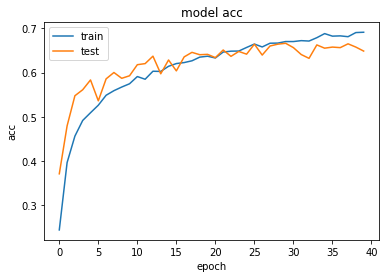

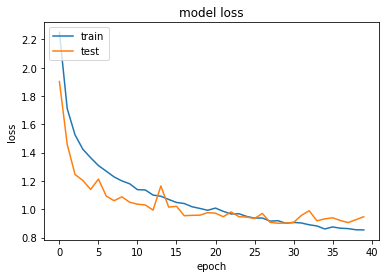

Max Validation accuracy:  0.6662556529045105


In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print ("Train accuracy: ", model_history.history['accuracy'][20])
print ("Max Validation accuracy: ", max(model_history.history['val_accuracy']))

###b) With 7 labels

In [ ]:
new_model = tf.keras.models.Sequential(model.layers[:-1])
new_model.add(Dense(7, activation='softmax'))
new_model.summary()

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
filepath ="weights_label7_2D/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True)
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = 'adam'
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

new_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=new_model.fit(X_train, y_train_enc2, batch_size=16, epochs=100, callbacks=[earlyStopping, model_checkpoint],
                        validation_data=(X_test, y_test_enc2))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 216, 32)       544       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 216, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 108, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 108, 32)       16416     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 108, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 54, 32)        

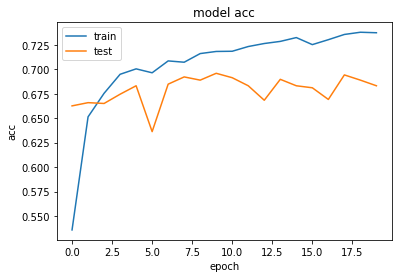

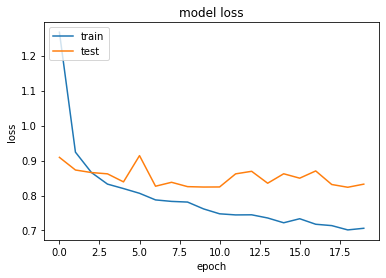

Max Validation accuracy:  0.6958487629890442


In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print ("Train accuracy: ", model_history.history['accuracy'][20])
print ("Max Validation accuracy: ", max(model_history.history['val_accuracy']))

In [ ]:
# model_json = new_model.to_json()

# with open("drive/MyDrive/AudioDatasets/audio_model7label_CNN.json", "w") as json_file:
#     json_file.write(model_json)

# new_model.save_weights("drive/MyDrive/AudioDatasets/audio_weights_7label_CNN.h5")

# json_file = open('drive/MyDrive/AudioDatasets/audio_model7label_CNN.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("drive/MyDrive/AudioDatasets/audio_weights_7label_CNN.h5")
# print("Loaded model from disk")

# loaded_model.save('drive/MyDrive/AudioDatasets/audio_model7label_CNN.hdf5')

In [ ]:
# new_model.load_weights("weights_label7_2D/weights-improvement-14-0.70.hdf5")

# new_model.save('drive/MyDrive/AudioDatasets/audio_model7label_CNN.hdf5')

# iv) Predictions

##a) Loads the saved model from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from keras.models import load_model
loaded_model = load_model('drive/MyDrive/AudioDatasets/audio_model7label_CNN.hdf5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 216, 32)       544       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 216, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 108, 32)       16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 108, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 54, 32)        

##b) Evaluates model on test data

In [ ]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
loaded_model.evaluate(X_test, y_test_enc2)

77/77 [==============================] - 1s 5ms/step - loss: 0.8060 - accuracy: 0.7089


[0.8092648386955261, 0.7028359770774841]

In [ ]:
# np.expand_dims(X_test[0], axis=0)
loaded_model.predict(np.expand_dims(X_test[0], axis=0))

array([[7.2303496e-02, 6.6343755e-01, 4.1047052e-02, 1.5767126e-01,
        3.8651899e-02, 2.6230844e-02, 6.5792777e-04]], dtype=float32)

In [ ]:
np.argmax(loaded_model.predict(np.expand_dims(X_test[0], axis=0)))

1

In [ ]:
dic = { 0: "Angry",
       1: "Disgust",
       2:"Fear",
       3:"Happy",
       4:"Sad",
       5:"Surprise",
       6:"Neutral"}

In [ ]:
count = 0
for i,j,k in zip(y_test, y_test2, y_test_enc2):
  print (i, j, np.argmax(k, axis=0))
  count+=1
  if (count==10):
    break

labelEncoder2.classes_

female_neutral neutral 4
male_sad sad 5
male_angry angry 0
female_surprise surprise 6
female_disgust disgust 1
female_happy happy 3
female_angry angry 0
female_surprise surprise 6
female_fear fear 2
female_angry angry 0


array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

In [ ]:
for i in range(20,30):
  print (y_test2[i], np.argmax(y_test_enc2[i], axis=0), np.argmax(loaded_model.predict(np.expand_dims(X_test[i], axis=0)))) 

surprise 6 6
neutral 4 4
surprise 6 6
neutral 4 4
surprise 6 2
sad 5 5
sad 5 4
disgust 1 1
angry 0 6
happy 3 3


##3) Gets a random video downloaded from youtube and predict the results

In [ ]:
df_pred = pd.DataFrame(columns=['features'])

filename = "song.mp3"
total_audio_time = librosa.get_duration(filename=filename)
offset = 1.5
duration = 2.5
sampling_rate= 44100

steps = int((total_audio_time-offset)/duration)
print (steps)
counter=0

n_mfcc = 30
X_in = np.empty(shape=(steps, n_mfcc, 216, 1))
for index in tqdm(range(steps)):
    X, sample_rate = librosa.load(filename, res_type='kaiser_fast',
                                  duration=2.5,sr=sampling_rate,offset=offset+(duration*index))
    sample_rate = np.array(sample_rate)
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_mfcc), axis=0)
    df_pred.loc[counter] = [mfccs]

    mfccs = np.expand_dims(mfccs, axis=-1)
    X_in[counter,] = mfccs

    counter=counter+1   

print(len(df_pred))
df_pred.head()


  0%|          | 0/46 [00:00<?, ?it/s]

46


100%|██████████| 46/46 [00:32<00:00,  1.40it/s]

46


features
0  [-10.492546605857159, -9.997289156672556, -8.2...
1  [-13.046385654014788, -11.531339244720785, -10...
2  [-5.18047048996364, -6.892807058143168, -11.57...
3  [-7.2410492461446125, -9.380366112414423, -12....
4  [-7.5755822475360395, -9.29523641386138, -9.46...

In [ ]:
df_pred = pd.DataFrame(df_pred['features'].values.tolist())
df_pred.head()

0          1          2    ...        213        214        215
0 -10.492547  -9.997289  -8.229578  ... -12.270458 -12.662697 -12.990674
1 -13.046386 -11.531339 -10.974881  ... -12.110805  -8.326477  -5.163420
2  -5.180470  -6.892807 -11.577694  ... -11.961203 -11.954950 -11.409485
3  -7.241049  -9.380366 -12.579060  ... -11.396179  -9.561219  -8.627559
4  -7.575582  -9.295236  -9.463426  ... -10.471998 -10.911316 -10.216134

[5 rows x 216 columns]

In [ ]:
X_in = (X_in - X_in.mean())/X_in.std()
X_in.shape

(46, 30, 216, 1)

In [ ]:
emotions = {'anger': 0, 'disgust':0, 'fear':0, 'happy':0, 'neutral':0, 'sad':0, 'surprise':0}
keys_list = list(emotions)
pred_array = []
for i in range(steps):
  pred = np.argmax(loaded_model.predict(np.expand_dims(X_in[i], axis=0)))
  pred_array.append(keys_list[pred])
  emotions[keys_list[pred]]+=1
# ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotions

{'anger': 16,
 'disgust': 0,
 'fear': 1,
 'happy': 1,
 'neutral': 0,
 'sad': 26,
 'surprise': 2}

In [ ]:
pred_array[0:10]

['anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger',
 'anger']

In [ ]:
loaded_model.predict(np.expand_dims(X_in[0], axis=0))

array([[9.7274446e-01, 7.0246753e-10, 2.4461178e-08, 2.7255544e-02,
        2.3617054e-12, 5.0804196e-13, 2.2803345e-14]], dtype=float32)